# Datos sintéticos C-Means

- author: Virginia Ordoño Bernier
- date_ April 2024

Utiliza el algoritmo C-Means para agrupar los datos del fichero synthetic_data2.csv y visualiza los resultados gráficamente.

Averigua el número de clusters óptimo utilizando Elbow y BIC.
Visualiza los resultados utilizando un gráfico de dispersión. Cada punto en el gráfico debe ser coloreado de acuerdo con el cluster al que pertenece y mostrar el grado de pertenencia.
Comprueba si este resultado coincide con la agrupación real que puedes encontrar en el fichero synthetic_data2_with_labels.csv. 

## 1. Carga de datos local

In [2]:
import sys
sys.path.append('./')
from my_utils import *
import pandas as pd # type: ignore

data_csv = '../data/synthetic_data2.csv'
df = pd.read_csv(data_csv)

data_labelled_csv = '../data/synthetic_data2_with_labels.csv'
df_labelled = pd.read_csv(data_labelled_csv)

df.head()

,x,y
0,11.121016,9.243988
1,11.285070,8.111599
2,3.845661,2.691864
3,10.298441,9.533195
4,7.883584,2.079705


### 1.1. Renombramos 'class' a 'cluster' porque es palabra reservada

In [3]:
df_labelled.rename(columns={'class': 'cluster'}, inplace=True)
df_labelled['cluster'] = df_labelled['cluster'].astype(int)
df_labelled.head()

,x,y,cluster
0,11.121016,9.243988,4
1,11.285070,8.111599,4
2,3.845661,2.691864,1
3,10.298441,9.533195,4
4,7.883584,2.079705,2


In [4]:
df_labelled.cluster.unique()

array([4, 1, 2, 3])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       400 non-null    float64
 1   y       400 non-null    float64
dtypes: float64(2)
memory usage: 6.4 KB


## 2. Visualización de la distribución de los datos

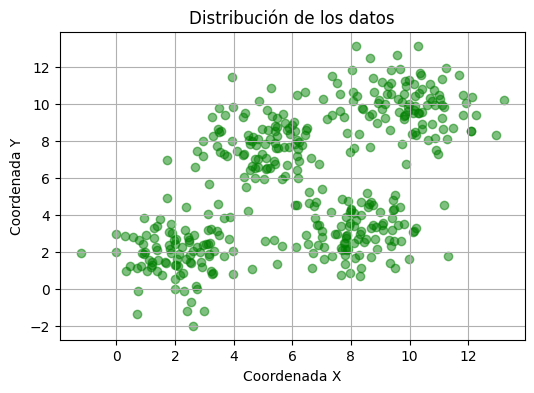

In [6]:
from matplotlib import pyplot as plt # type: ignore

plt.figure(figsize=(6, 4))
plt.scatter(df['x'], df['y'], color='green', alpha=0.5)  

plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Distribución de los datos')

plt.grid(True)
plt.show()

## 3. Gráficos BIC y Elbow

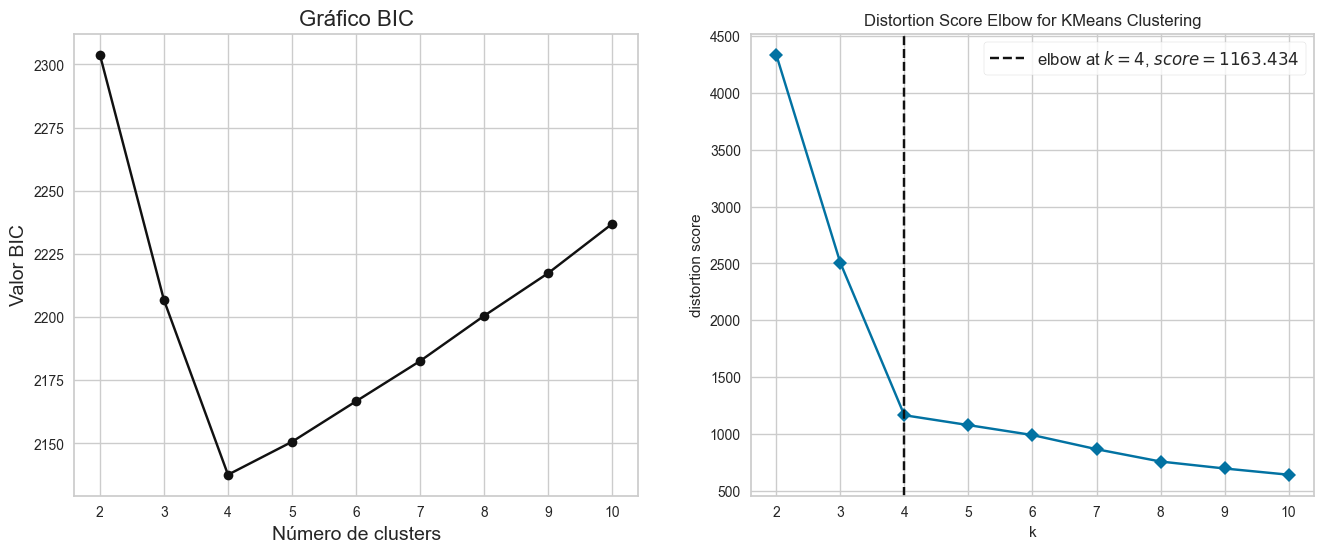

<Figure size 800x550 with 0 Axes>

Mejor k según BIC: 4
Mejor k según Elbow: 4


In [7]:
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
from sklearn.cluster import KMeans # type: ignore
from yellowbrick.cluster import KElbowVisualizer # type: ignore

bic_array = []
K_MAX = 10
K_MIN = 2
N_INIT = 20
RANDOM_STATE= 42

for k in range(K_MIN, K_MAX+1):
    model_bic = KMeans(n_clusters=k, n_init=N_INIT, random_state=RANDOM_STATE)
    groups_bic = model_bic.fit_predict(df)
    bic_array.append(get_bic_values(k, groups_bic, df.values))
        
# Visualización de los resultados con BIC 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.arange(K_MIN, K_MAX+1), bic_array, "ko-")
ax1.set_xticks(range(K_MIN, K_MAX+1))
ax1.set_title("Gráfico BIC", fontsize=16)
ax1.set_xlabel("Número de clusters", fontsize=14)
ax1.set_ylabel("Valor BIC", fontsize=14)

# Visualización de los resultados con Elbow Method
elbow_method = KElbowVisualizer(KMeans(random_state=RANDOM_STATE), k=K_MAX, timings=False)
elbow_method.fit(df)
elbow_method.show()

plt.tight_layout()
plt.show()

# Leyendas

# Obtiene el número óptimo de clusters según el método BIC
k_bic = np.argmin(bic_array) + K_MIN

# Obtiene el número óptimo de clusters según el método del codo
k_elbow = elbow_method.elbow_value_

print(f"Mejor k según BIC: {k_bic}")
print(f"Mejor k según Elbow: {k_elbow}")

## 4. Modelo C-means con los mejores parámetros

In [8]:
from skfuzzy.cluster import cmeans # type: ignore

# Parámetros de entrada
# - dataframe.T: Matriz de datos transpuesta [N: número de variables, S: número de individuos] estructura del algoritmo
# - K: Número de clusters que se desean obtener
# - m: Parámetro de FCM. Controla el nivel de difusión de la pertenencia de los individuos a los clusters. 
# Por defecto es 2
# - tolerancia: Criterio de parada del algoritmo. 
# Cuando la diferencia entre dos iteraciones consecutivas sea menor que este valor, el algoritmo se detiene
# - maxiter: Límite máximo de iteraciones antes de detener el algoritmo
# - seed: Semilla para la generación de números aleatorios

# Parámetros de salida
# - centroids: Array bidimensional con las coordenadas de los centroides de los clusters. 
# - membership_matrix: Array bidimensional con los valores de pertenencia de los individuos a los clusters.
# - initial_membership_matrix: Valores de pertenencia de los individuos a los clusters en la primera iteración
# - distances_matrix: matriz de distancias entre los individuos y los centroides de los clusters en la última iteración
# - historic: Array con los valores de la función objetivo en cada iteración
# - total_iter: Número total de iteraciones realizadas por el algoritmo
# - fpc: Coeficiente de partición difusa final. Cuantifica la calidad de la partición difusa obtenida

K = k_bic
FUZZY_LEVEL = 2 
TOLERANCE = 1e-5 
MAX_ITER = 100 
SEED = 100

centroids, membership_matrix, initial_membership_matrix, distances_matrix, historic, p, fpc = cmeans(df.T, K, FUZZY_LEVEL, TOLERANCE, MAX_ITER, seed=SEED)

### 4.1. Matriz de pertenencia

In [9]:
# Cada fila es un cluster y cada columna un individuo con su grado de pertenencia correspondiente
matrix_mem = pd.DataFrame(membership_matrix.T, columns=[f"Grupo_{i}" for i in range(K)])

# El cluster al que pertenece cada individuo es aquel con mayor grado de pertenencia
matrix_mem["Cluster"] = np.argmax(membership_matrix, axis=0)

# El grado de pertenencia al cluster es el máximo valor de la fila
degree_mem = np.amax(membership_matrix, axis=0)

matrix_mem

,Grupo_0,Grupo_1,Grupo_2,Grupo_3,Cluster
0,0.012384,0.044426,0.907117,0.036073,2
1,0.032062,0.103995,0.750679,0.113263,2
2,0.731650,0.095231,0.029765,0.143355,0
3,0.002480,0.010578,0.980168,0.006774,2
4,0.030497,0.024803,0.015195,0.929506,3
...,...,...,...,...,...
395,0.024859,0.029147,0.023842,0.922152,3
396,0.075606,0.049194,0.027799,0.847401,3
397,0.042170,0.419797,0.462505,0.075528,2
398,0.001703,0.992584,0.003108,0.002605,1


### 4.2.  Visualización Fuzzy-means vs. Etiquetas reales

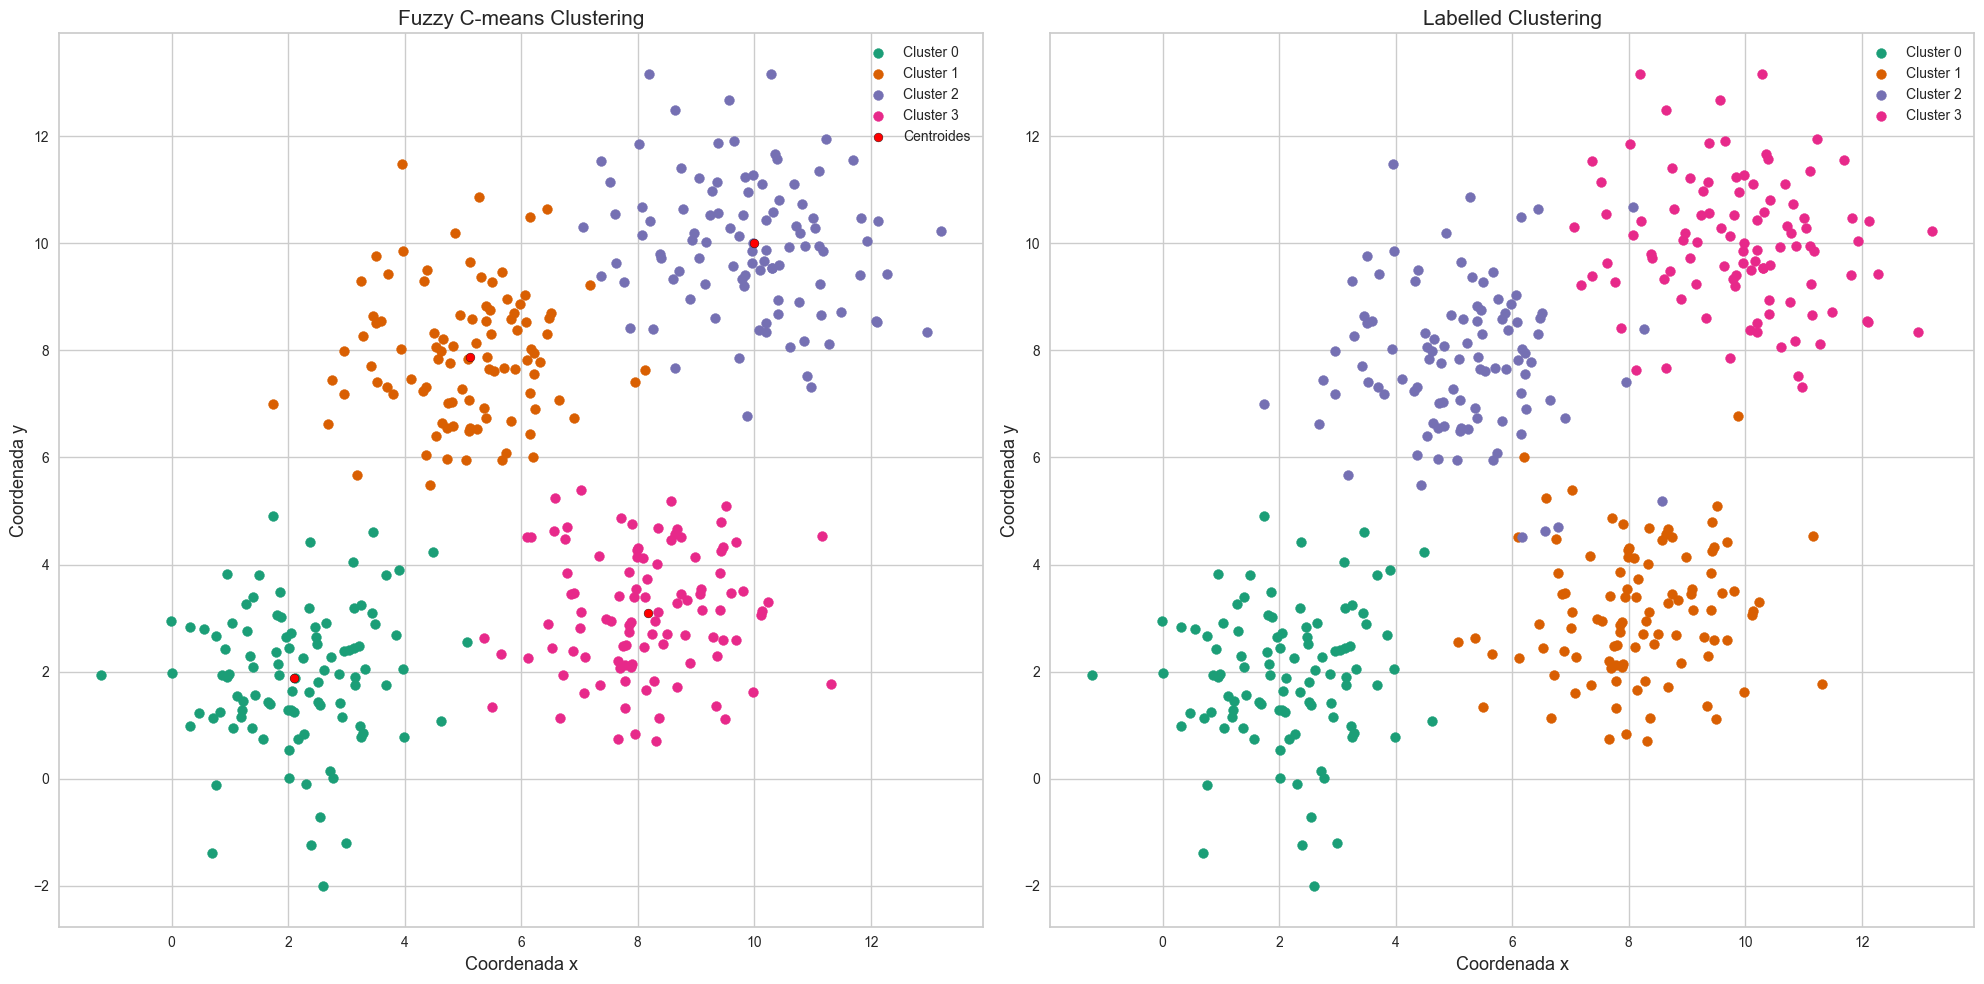

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
colors = plt.colormaps['Dark2']

groups = np.argmax(membership_matrix, axis=0) 
unique_labels = set(groups)

# Gráfico 1: Fuzzy C-Means
for i, label_value in enumerate(unique_labels):
    cluster_mask = (groups == label_value)
    ax1.scatter(df.loc[cluster_mask, "x"], df.loc[cluster_mask, "y"], color=colors(i), label=f'Cluster {label_value}', s=50)

ax1.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=40, color='red', edgecolor='k', label='Centroides')
ax1.set_title("Fuzzy C-means Clustering", fontsize=15)
ax1.set_xlabel('Coordenada x', fontsize=13)
ax1.set_ylabel('Coordenada y', fontsize=13)
ax1.grid(True)
ax1.legend()

# Gráfico 2. Datos con etiquetas de cluster
df_labelled.cluster.replace({1: 0, 2:1, 3:2, 4:3}, inplace=True)
unique_labels = set(df_labelled.cluster)

for i, label in enumerate(unique_labels):
    cluster_mask = (df_labelled['cluster'] == label)
    ax2.scatter(df_labelled.loc[cluster_mask, "x"], df_labelled.loc[cluster_mask, "y"], color=colors(i), label=f'Cluster {label}', s=50)

ax2.set_title("Labelled Clustering", fontsize=15)
ax2.set_xlabel('Coordenada x', fontsize=13)
ax2.set_ylabel('Coordenada y', fontsize=13)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

### 6. Detección de outliers

- Utilizaremos la variable distances_matrix

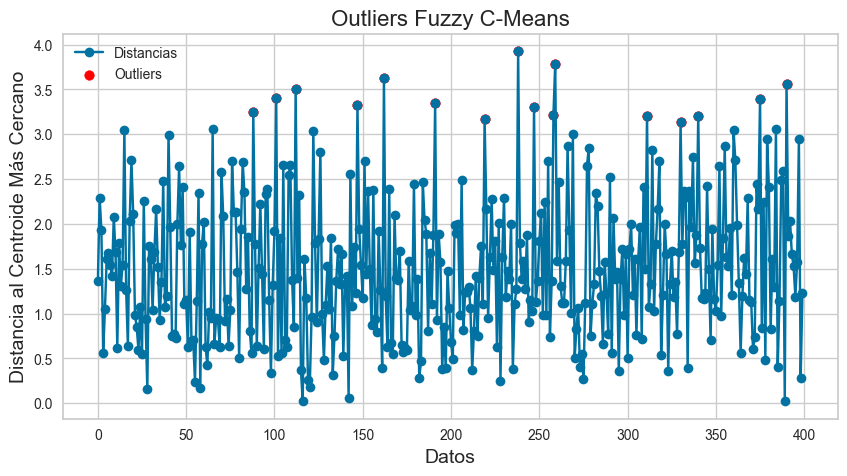

In [11]:
distances = np.min(distances_matrix, axis=0)  # Distancias al centroide más cercano

# Calcular la métrica de dispersión
sigma = np.std(distances)  # Desviación típica de las distancias. Devuelve la raíz cuadrada de la varianza de las distancias
mu = np.mean(distances)  # Devuelve la media de las distancias al centroide más cercano
umbral = 2  # Umbral: 2 para distribuciones normales y 3 para cualquier otra distribución

# 1. Iterar sobre los índices de distances.
# 2. Crea una secuencia de números desde 0 hasta el tamaño de distances menos uno, que son los índices de los puntos en los datos.
# 3. Para cada punto, calcula la desviación absoluta de su distancia mínima al centroide (almacenada en distances[i]) con respecto a la media de todas las distancias (mu).
# 4. Si la desviación es mayor que el umbral * sigma, entonces el punto es un outlier.
outliers = [i for i in range(len(distances)) if np.abs(distances[i] - mu) > umbral * sigma]

# Crear un DataFrame para mostrar los outliers
outliers_df = pd.DataFrame({'Index': outliers, 'Distance': [distances[idx] for idx in outliers]})

# Visualización
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(distances)), distances, "bo-", label='Distancias')
plt.scatter(outliers, [distances[idx] for idx in outliers], color='red', label='Outliers')
plt.title("Outliers Fuzzy C-Means", fontsize=16)
plt.xlabel("Datos", fontsize=14)
plt.ylabel("Distancia al Centroide Más Cercano", fontsize=14)
plt.legend()
plt.show()


In [12]:
outliers_df

,Index,Distance
0,88,3.244201
1,101,3.399701
2,112,3.507599
3,147,3.320925
4,162,3.630211
5,191,3.350489
6,219,3.167959
7,238,3.926262
8,247,3.306517
9,258,3.217429
